In [1]:
%pylab inline
from __future__ import division
import scipy as sp
from scipy import stats
from scipy.signal import argrelextrema
from scipy.interpolate import interp1d
import operator as op
from decimal import *
# import pickle
# from mpl_toolkits.mplot3d import Axes3D
import mpld3
mpld3.enable_notebook()

Populating the interactive namespace from numpy and matplotlib


In [279]:
%run ../cow.py
%run ../optimize_pkg_2.py

In [7]:
codingscheme = filepath_down = "../data_tables/hs_rs_downlink"
filepath_up = "../data_tables/hs_rs_uplink/n"
protocolbit = 4*10**4
protocol_target = 10**(-9)

In [4]:
start_node = 2
end_node = 36

In [251]:
tSNR_range = np.arange(0, 40, 1)
rSNR1_range = np.arange(-1, 7, 0.01)

In [262]:
%%time
# Loudest Talker No Fade Gap
N = 3

filename = codingscheme + '/n' + str(N) + '.in'
downTable = load_table(filename)
downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

padd = 0.1*protocol_target
rSNR2 = downTable[0][np.where(np.array(downTable[1])<=pa2)[0][0]]

tSNR_range = [33] # 32.97
actualSNR = rSNR2

for tSNR in tSNR_range:
# pprotocol = 1.0
# while pprotocol > target:
#     SNR += dSNR
    hcrit = 10**((actualSNR - tSNR)/10) # linear fade
    pbadfade = 1 - np.exp(-hcrit)
    psingle = pbadfade + (1-pbadfade)*padd

    pprotocol = 0
    for a in range(N):
        z = nCr(N, a) * (1-psingle)**a * psingle**(N-a) * (1-(1-(pbadfade**a + (1-pbadfade**a) * padd))**(N-a))
        pprotocol += z
        print a, z, pprotocol

0 9.74317412657e-11 9.74317412657e-11
1 5.84187009866e-10 6.81618751132e-10
2 2.92164077302e-10 9.73782828433e-10
CPU times: user 31.7 ms, sys: 6.68 ms, total: 38.4 ms
Wall time: 58.1 ms


In [263]:
%%time
# Loudest Talker with Fade Gap
N = 3

filename = codingscheme + '/n' + str(N) + '.in'
downTable = load_table(filename)
downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

pa2 = 0.1*protocol_target
rSNR2 = downTable[0][np.where(np.array(downTable[1])<=pa2)[0][0]]

tSNR_range = [33] # 32.97
rSNR1_range = [rSNR2]
# rSNR1_range = [6.85]

for tSNR in tSNR_range:
    h2 = 10**((rSNR2 - tSNR)/10)
    pf2 = 1 - np.exp(-h2)
#     p2 = pf2 + (1-pf2)*pa2
    for rSNR1 in rSNR1_range:
        pa1 = downfunc(rSNR1)
        h1 = 10**((rSNR1 - tSNR)/10) # linear fade
        pf1 = 1 - np.exp(-h1)
        pf1 = 1 - np.exp(-h1)
        pf2c = 1
        # pf2c = 1 - np.exp(h1-h2) if h2 > h1 else 0
        rv_g = binom(N, 1 - pf1)
        result = 0 # rv_g.pmf(0)
        for g in xrange(1, N+1, 1):
            rv_a = binom(g, 1 - pa1)
            a_range = np.arange(0, g+1, 1)
            # qE = np.power(p2, a_range)
            qpf2 = np.power(pf2, a_range)
            qE = qpf2 + (1-qpf2)*pa2
            qB = qpf2 * pf2c + (1 - qpf2*pf2c)*pa2
            # qB = qE * (pf2c + (1 - pf2c)*pa2)
            psuccess = (1-qE)**(N-g) * np.power((1-qB), g-a_range)
            z = rv_g.pmf(g) * np.dot(rv_a.pmf(a_range), 1-psuccess)
            result += z
            print g, z, result
#             if result > protocol_target:
#                 break
#         if result < protocol_target:
#             print "N {0}, tSNR {1}, rSNR1 {2}, result {3}".format(N, tSNR, rSNR1, result)
#             break
#     if result < protocol_target:
#         break

1 5.84186809669e-10 5.84186809669e-10
2 2.92164228052e-10 8.76351037721e-10
3 5.35641441242e-17 8.76351091285e-10
CPU times: user 30.2 ms, sys: 7.07 ms, total: 37.3 ms
Wall time: 38.2 ms


In [266]:
%%time
# tSNR_range = np.arange(0, 92, 1)
rSNR1_range = np.arange(-1, 7, 0.01)

tSNR_range = [32.97]

for N in [3]:
    filename = codingscheme + '/n' + str(N) + '.in'
    downTable = load_table(filename)
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

#     tSNR_range = np.arange(downlink_dct[N][0], downlink_dct[N][1], 0.01)
#     rSNR1_range = np.arange(-1, 5, 0.01)
    
    pa2 = 0.1*protocol_target
    rSNR2 = downTable[0][np.where(np.array(downTable[1])<=pa2)[0][0]]

    z = down_fade_gap_inner(N, downfunc, protocol_target, tSNR_range, rSNR1_range, rSNR2, pa2)
    print z

[  3.    32.97  -0.76  -0.37]
CPU times: user 103 ms, sys: 6.63 ms, total: 110 ms
Wall time: 132 ms


In [286]:
%%time
res = np.zeros((35-2+1, 4))

# tSNR_range = np.arange(5, 90, 1)
# rSNR1_range = np.arange(-1, 7, 0.01)

for N in xrange(35, 1, -1):
    filename = codingscheme + '/n' + str(N) + '.in'
    downTable = load_table(filename)
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

    tSNR_range = np.arange(downlink_dct[N][0], 92, 0.01)
#     tSNR_range = np.arange(downlink_dct[N][0], downlink_dct[N][1], 0.01)
    rSNR1_range = np.arange(np.floor(downlink_dct[N][1]), np.ceil(downlink_dct[N][1]), 0.01)
    
    pa2 = 0.1*protocol_target
    rSNR2 = downTable[0][np.where(np.array(downTable[1])<=pa2)[0][0]]

    res[N-2] = down_fade_gap_inner(N, downfunc, protocol_target, tSNR_range, rSNR1_range, rSNR2, pa2)
    print res[N-2]

[ 35.    10.81   4.83   6.85]
[ 34.     9.53   3.86   5.14]
[ 33.     8.97   3.31   4.37]
[ 32.     8.68   2.97   3.92]
[ 31.     8.44   2.66   3.53]
[ 30.     8.27   2.39   3.21]
[ 29.     8.85   1.99   2.97]
[ 28.     8.1    1.99   2.73]
[ 27.     8.05   1.8    2.51]
[ 26.     8.06   1.66   2.35]
[ 25.     8.06   1.5    2.16]
[ 24.     8.09   1.36   1.99]
[ 23.     8.17   1.24   1.86]
[ 22.     8.38   0.99   1.71]
[ 21.     8.36   0.96   1.56]
[ 20.     8.51   0.86   1.44]
[ 19.     8.68   0.72   1.31]
[ 18.     8.88   0.6    1.18]
[ 17.     9.13   0.51   1.08]
[ 16.     9.41   0.39   0.96]
[ 15.     9.74   0.27   0.84]
[ 14.    10.14   0.18   0.74]
[  1.30000000e+01   1.07600000e+01  -1.00000000e-02   6.30000000e-01]
[ 12.    11.14  -0.03   0.52]
[ 11.    11.8   -0.1    0.43]
[ 10.    12.58  -0.18   0.32]
[  9.    13.56  -0.3    0.22]
[  8.    14.79  -0.37   0.13]
[  7.    16.35  -0.45   0.02]
[  6.    18.44  -0.54  -0.08]
[  5.    21.35  -0.59  -0.17]
[  4.    25.65  -0.65  -0.27]


In [285]:
# downlink_dct = {}

for N_array in res:
    N = N_array[0]
    if not np.isnan(N):
#         tmp = N_array[1] - 1 if N_array[1] % 10 == 0 else N_array[1]
        downlink_dct[N] = (N_array[1] - 0.1, N_array[2])

In [282]:
print downlink_dct

{0.0: (-0.10000000000000001, 0.0), 2.0: (45.0, -0.69999999999999973), 3.0: (32.0, -0.78999999999999981), 4.0: (25.0, -0.75999999999999979), 5.0: (21.0, -0.72999999999999976), 6.0: (18.0, -0.66999999999999971), 7.0: (16.0, -0.59999999999999964), 8.0: (14.0, -0.45999999999999952), 9.0: (13.0, -0.41999999999999948), 10.0: (12.0, -0.3299999999999994), 11.0: (11.0, -0.19999999999999929), 12.0: (11.0, -0.18999999999999928), 13.0: (10.0, -0.049999999999999156), 14.0: (10.0, 0.010000000000000897), 15.0: (9.0, 0.16000000000000103), 16.0: (9.0, 0.23000000000000109), 17.0: (9.0, 0.32000000000000117), 18.0: (8.0, 0.52000000000000135), 19.0: (8.0, 0.59000000000000141), 20.0: (8.0, 0.68000000000000149), 21.0: (8.0, 0.77000000000000157), 22.0: (8.0, 0.89000000000000168), 23.0: (8.0, 1.0200000000000018), 24.0: (8.0, 1.1400000000000019), 25.0: (8.0, 1.280000000000002), 26.0: (8.0, 1.4400000000000022), 27.0: (8.0, 1.5800000000000023), 28.0: (8.0, 1.7700000000000022), 29.0: (8.0, 1.9800000000000026), 30.

In [287]:
# lt_fadegap_1 = res
lt_fadegap_2 = res

In [ ]:
%%time

# final_res = np.zeros((35-2+1, 4))

tSNR_range = np.arange(0, 40, 1)
rSNR1_range = np.arange(-1, 7, 0.01)

for N in xrange(2, 36, 1):
    filename = codingscheme + '/n' + str(N) + '.in'
    downTable = load_table(filename)
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

#     tSNR_range = np.arange(downlink_dct[N][0], downlink_dct[N][1], 0.1)
#     rSNR1_range = np.arange(np.floor(downlink_dct[N][2]), np.ceil(downlink_dct[N][2]), 0.01)
    
    pa2 = 0.1*protocol_target
    rSNR2 = codetable[0][np.where(np.array(codetable[1])<=pa2)[0][0]]

    res[N-2] = down_fade_gap_inner(N, downfunc, protocol_target, tSNR_range, rSNR1_range, rSNR2, pa2)
    print res[N-2]

In [102]:
%%time

# final_res = np.zeros((36-2+1, 4))

for N in [30, 19, 12]:
    filename = codingscheme + '/n' + str(N) + '.in'
    downTable = load_table(filename)
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

    tSNR_range = np.arange(downlink_dct[N][0], downlink_dct[N][1]+0.1, 0.01)
    rSNR1_range = np.arange(np.floor(downlink_dct[N][2]), np.ceil(downlink_dct[N][2]), 0.01)
    
    pa2 = 0.1*protocol_target
    rSNR2 = codetable[0][np.where(np.array(codetable[1])<=pa2)[0][0]]

    final_res[N-2] = down_fade_gap_inner(N, downfunc, protocol_target, tSNR_range, rSNR1_range, rSNR2, pa2)
    print final_res[N-2]

[ 30.    10.2    2.44   6.85]
[ 19.    11.8    0.77   6.85]
[  1.20000000e+01   1.44000000e+01  -1.00000000e-02   6.85000000e+00]
CPU times: user 47.3 s, sys: 309 ms, total: 47.7 s
Wall time: 50.8 s


In [116]:
# downlink_fadegap = final_res[:-1,:]
print downlink_fadegap[:,1]

[ 35.34  28.99  24.97  22.22  20.21  18.69  17.48  16.49  15.67  14.98
  14.4   13.87  13.42  13.02  12.67  12.35  12.06  11.8   11.57  11.36
  11.16  10.99  10.83  10.69  10.56  10.45  10.37  10.27  10.2   10.16
  10.16  10.17  10.28  10.65]


In [109]:
%%time
dSNR = 0.01
target = 10**(-9)
paddratio = 0.1 # padd = 10**(-10)
start_SNR = 0
start_nodes, end_nodes = 2, 36

hsrsscheme = '../data_tables/hs_rs_downlink'
hsrs_down = loudest_talker(hsrsscheme, dSNR, target, paddratio, start_SNR, start_nodes, end_nodes)

CPU times: user 4.76 s, sys: 82.7 ms, total: 4.85 s
Wall time: 5.34 s


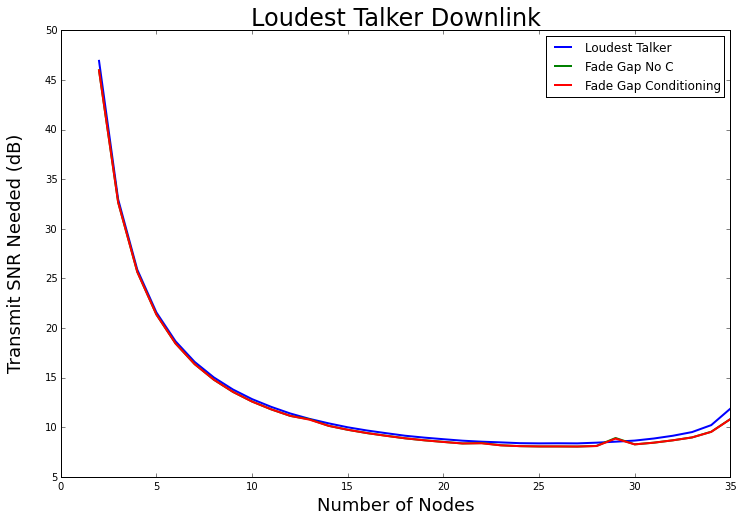

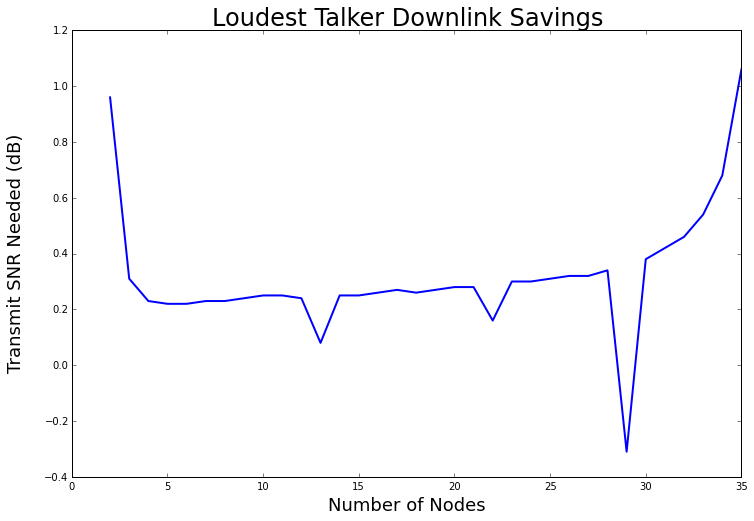

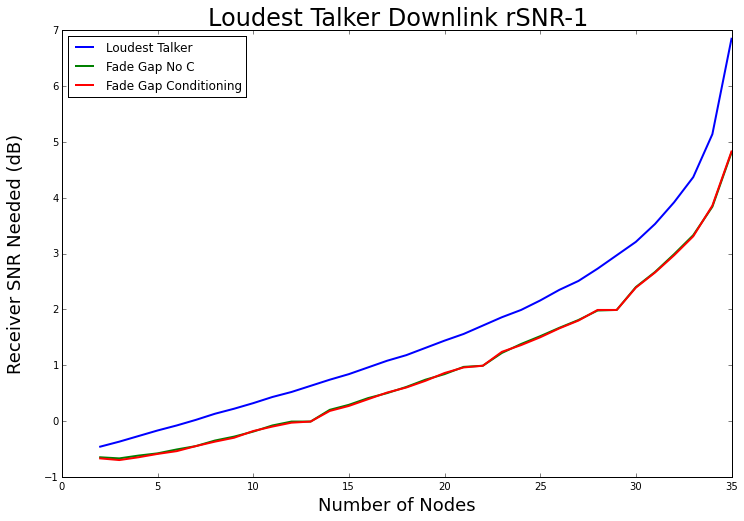

In [299]:
user_range = range(start_nodes, end_nodes)

figure(figsize=(12, 8))
plot(user_range, hsrs_down, lw=2.0, label='Loudest Talker')
plot(user_range, lt_fadegap_1[:,1], lw=2.0, label='Fade Gap No C')
plot(user_range, lt_fadegap_2[:,1], lw=2.0, label='Fade Gap Conditioning')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Transmit SNR Needed (dB)', fontsize=18, labelpad=20)
title('Loudest Talker Downlink', fontsize=24)
savefig('loudest_talker_comparison.pdf', bbox='tight')

figure(figsize=(12, 8))
plot(user_range, hsrs_down-lt_fadegap_2[:,1], lw=2.0, label='Loudest Talker')
# legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Transmit SNR Needed (dB)', fontsize=18, labelpad=20)
title('Loudest Talker Downlink Savings', fontsize=24)
savefig('loudest_talker_savings.pdf', bbox='tight')

figure(figsize=(12, 8))
plot(user_range, lt_fadegap_1[:,3], lw=2.0, label='Loudest Talker')
plot(user_range, lt_fadegap_1[:,2], lw=2.0, label='Fade Gap No C')
plot(user_range, lt_fadegap_2[:,2], lw=2.0, label='Fade Gap Conditioning')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('Receiver SNR Needed (dB)', fontsize=18, labelpad=20)
title('Loudest Talker Downlink rSNR-1', fontsize=24)
savefig('loudest_talker_rSNR.pdf', bbox='tight')

In [119]:
print hsrs_down

[ 46.93  32.97  25.88  21.57  18.66  16.58  15.02  13.8   12.83  12.05
  11.38  10.84  10.39   9.99   9.67   9.4    9.14   8.95   8.79   8.64
   8.54   8.47   8.39   8.37   8.38   8.37   8.44   8.54   8.65   8.86
   9.14   9.51  10.21  11.87]


$$ q = p_\text{fade_2}^{a+1} + \left( 1 - p_\text{fade_2}^{a+1} \right) \cdot p_\text{add_2} $$

$$ \text{P(fail)} = \sum_g \sum_a {N \choose g} (1 - p_{f1})^g p_{f1}^{N-g} {g \choose a} (1 - p_{a1})^a p_{a1}^{g-a} \cdot \left( 1 - (1-q)^{N-a} \right) $$

In [232]:
# print final_res[:,1]
downlink_fadegap_1 = final_res[:-1, 1]
print downlink_fadegap_1

[ 49.61  36.38  29.52  25.33  22.49  20.44  18.87  17.63  16.63  15.8   15.1
  14.68  13.96  13.5   13.1   12.73  12.41  12.12  11.85  11.61  11.54
  11.2   11.02  10.85  10.71  10.57  10.47  10.98  10.27  10.21  10.18
  10.16  10.23  10.51]


In [290]:
print lt_fadegap_1[:,1]

print '\n'

print lt_fadegap_2[:,1]

[ 45.98  32.67  25.66  21.36  18.44  16.36  14.79  13.56  12.59  11.8
  11.14  10.8   10.14   9.74   9.41   9.14   8.88   8.68   8.52   8.36
   8.4    8.18   8.09   8.06   8.06   8.05   8.11   8.91   8.27   8.44
   8.68   8.97   9.54  10.82]


[ 45.97  32.66  25.65  21.35  18.44  16.35  14.79  13.56  12.58  11.8
  11.14  10.76  10.14   9.74   9.41   9.13   8.88   8.68   8.51   8.36
   8.38   8.17   8.09   8.06   8.06   8.05   8.1    8.85   8.27   8.44
   8.68   8.97   9.53  10.81]


In [294]:
r_probs = np.zeros((35-2+1, 2))

for N in range(2, 36, 1):
    idx = N - 2
    rSNR1, rSNR2 = lt_fadegap_2[idx,2], lt_fadegap_2[idx, 3]
    
    filename = codingscheme + '/n' + str(N) + '.in'
    downTable = load_table(filename)
    downfunc = interp1d(downTable[0], downTable[1], kind='linear', bounds_error=False, fill_value=(1.0, 0.0))

    p1, p2 = downfunc(rSNR1), downfunc(rSNR2)
    r_probs[idx] = np.array([p1, p2])
    
print r_probs

[[  2.66833477e-07   9.86078780e-11]
 [  9.93321181e-06   8.44009046e-11]
 [  4.16900634e-05   8.77497409e-11]
 [  1.24193540e-04   9.27321397e-11]
 [  3.12417677e-04   8.24799124e-11]
 [  4.25171721e-04   9.14957383e-11]
 [  7.28224183e-04   6.86528182e-11]
 [  1.11540043e-03   6.67783124e-11]
 [  8.12417659e-04   8.40982304e-11]
 [  1.43191295e-03   7.33903522e-11]
 [  2.25783157e-03   8.29431868e-11]
 [  1.15428202e-02   8.33094857e-11]
 [  2.73001958e-03   9.16937449e-11]
 [  3.09072439e-03   8.49846512e-11]
 [  2.77861827e-03   7.55219950e-11]
 [  2.62683339e-03   7.68204343e-11]
 [  3.35442773e-03   9.88652085e-11]
 [  3.54576594e-03   8.98003743e-11]
 [  2.76884086e-03   9.91864729e-11]
 [  3.48917582e-03   9.13079452e-11]
 [  1.99272176e-02   7.08610859e-11]
 [  3.35301979e-03   7.42622059e-11]
 [  3.82112184e-03   9.57529982e-11]
 [  5.04955072e-03   9.28435728e-11]
 [  5.58917961e-03   6.95861094e-11]
 [  6.77066530e-03   9.53404729e-11]
 [  6.92053461e-03   8.14971821e-11]
 

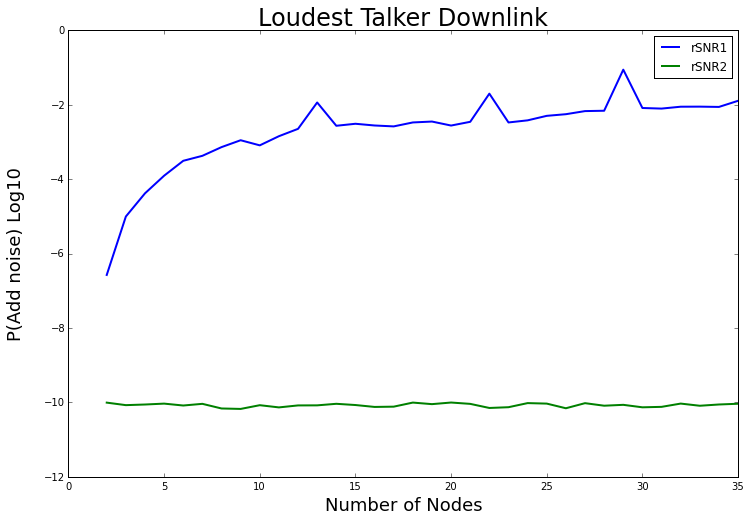

In [298]:
figure(figsize=(12, 8))
plot(user_range, np.log10(r_probs[:,0]), lw=2.0, label='rSNR1')
plot(user_range, np.log10(r_probs[:,1]), lw=2.0, label='rSNR2')
legend(loc=0)
xlabel('Number of Nodes', fontsize=18)
ylabel('P(Add noise) Log10', fontsize=18, labelpad=20)
title('Loudest Talker Downlink', fontsize=24)
savefig('loudest_talker_rprobs.pdf', bbox='tight')